# Introduction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Preparation

In [11]:
# Read in csv file, set date to datetime and as index
df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [12]:
# display data information
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [13]:
# Resample data by 1 hour and sum up number of orders
df_resamp = df.resample('1H').sum()

## Analysis

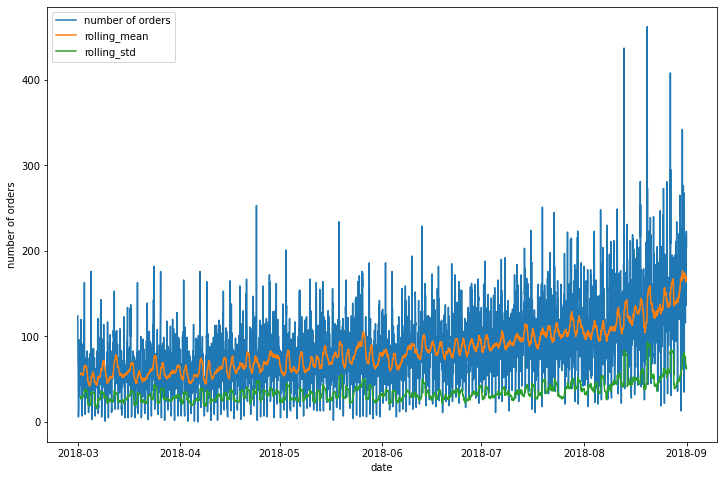

In [14]:
# Plot data
data = df_resamp.copy()
# rolling mean and std
data['rolling_mean'] = df_resamp['num_orders'].rolling(24).mean()
data['rolling_std'] = df_resamp['num_orders'].rolling(24).std()

plt.figure(figsize=(12,8))
plt.plot(data)
plt.xlabel('date')
plt.ylabel('number of orders')
plt.legend(['number of orders', 'rolling_mean', 'rolling_std'])
plt.show()

In [15]:
# analyze trend, seasonality, and residuals
decomposed = seasonal_decompose(df_resamp)

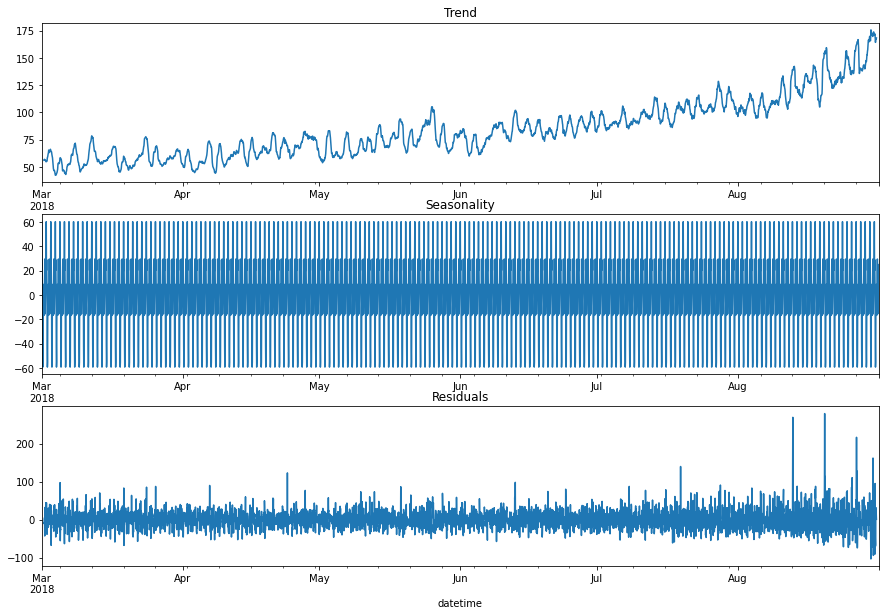

In [16]:
# plotting of trends and seasonality
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

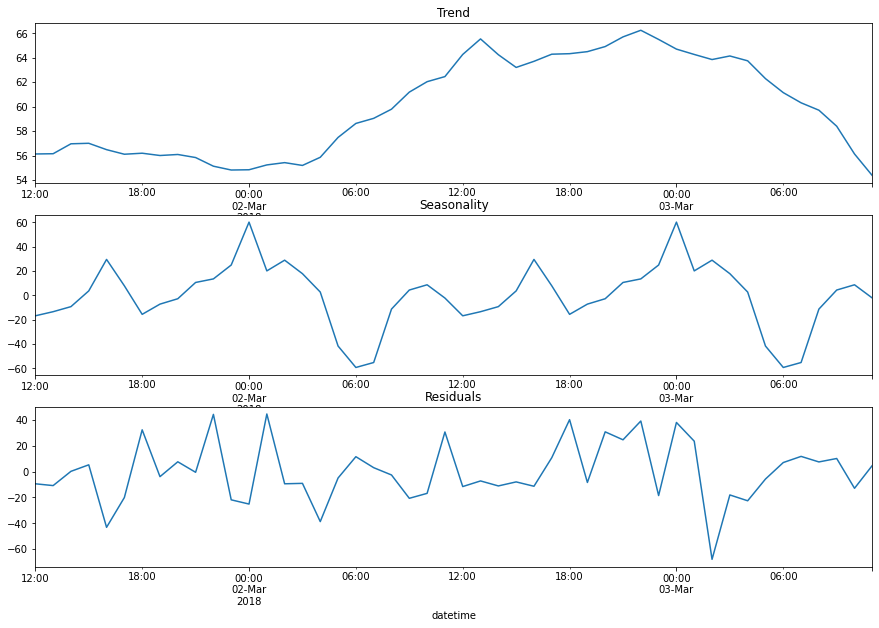

In [17]:
# looking at small slice for data
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend[12:60].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal[12:60].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid[12:60].plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

Observe seasonality of the data depending on the time of the day. Peaks and valleys occuring at similar times of the day.

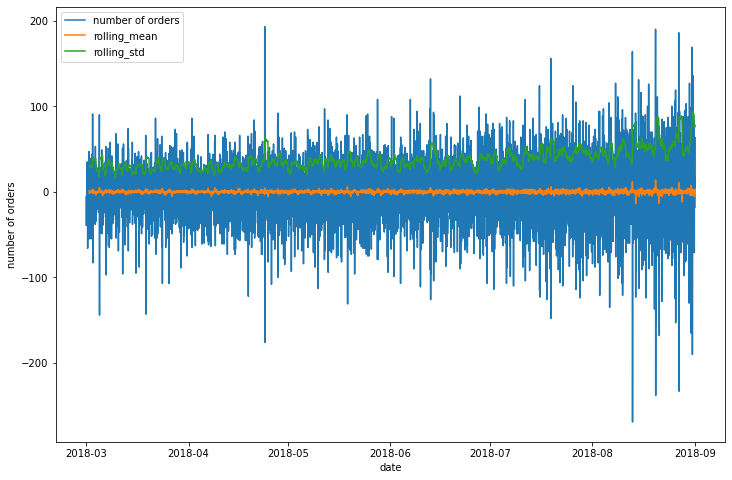

In [18]:
# time series differences
data_diff = df_resamp.copy()
data_diff = data_diff - data_diff.shift()

data_diff['rolling_mean'] = data_diff['num_orders'].rolling(24).mean()
data_diff['rolling_std'] = data_diff['num_orders'].rolling(24).std()

plt.figure(figsize=(12,8))
plt.plot(data_diff)
plt.xlabel('date')
plt.ylabel('number of orders')
plt.legend(['number of orders', 'rolling_mean', 'rolling_std'])
plt.show()

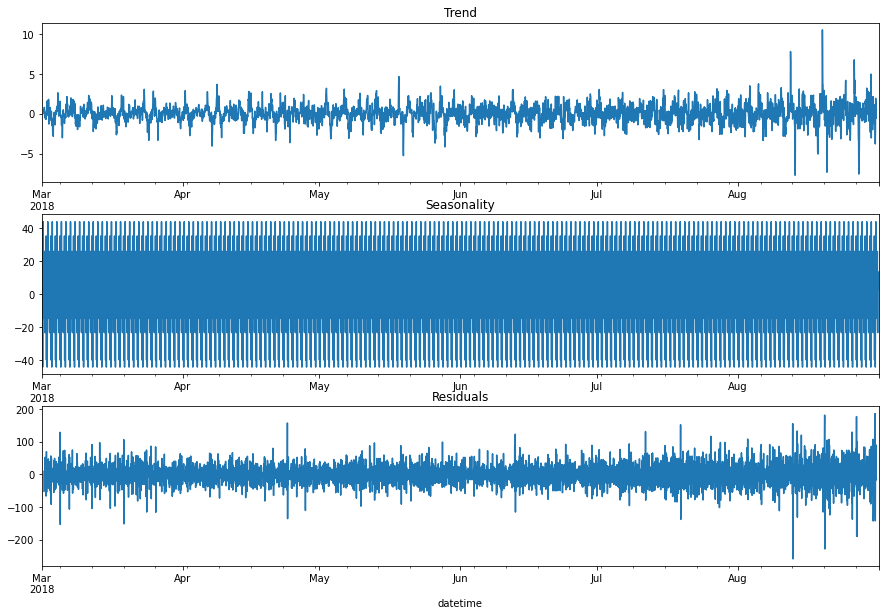

In [19]:
# analyze trend, seasonality, and residuals
# on time shifted difference data
data_diff = df_resamp.copy()
data_diff = data_diff - data_diff.shift(fill_value=0)
decomposed = seasonal_decompose(data_diff)

# plotting of trends and seasonality
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

Trend from original data shows that it is increasing over time, and that the data can be made stationary by transforming data using time difference.

Seasonality can be observed in the data since we see periodic repetition.

## Training

In [20]:
df_resamp.info()
display(df_resamp.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [21]:
# Create features
def make_features(data, max_lag, rolling_mean_size):
    
    # date features
    df_resamp['month'] = data.index.month
    df_resamp['day'] = data.index.day
    df_resamp['dayofweek'] = data.index.dayofweek
    df_resamp['hour'] = data.index.hour

    # lag features
    for lag in range(1, max_lag + 1):
        df_resamp['lag_{}'.format(lag)] = df_resamp['num_orders'].shift(lag)

    # rolling mean feature
    df_resamp['rolling_mean'] = df_resamp['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
make_features(df_resamp, 5, 10)

In [23]:
df_resamp.info()
display(df_resamp.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   hour          4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  rolling_mean  4406 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 414.0 KB


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,NaN


In [24]:
# split data into train and test sets 90/10
train, test = train_test_split(df_resamp, test_size=0.1, shuffle=False)

# remove null values in train
train = train.dropna()

In [25]:
# separate into features and target
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [26]:
# Linear regression
model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')
print('Average model evaluation score:', scores_lr.mean())

Average model evaluation score: -30.637325730156487


In [27]:
# LightGBM training
param_grid_lgb = {
    'max_depth': list(range(1, 11)),
    'n_estimators': list(range(100, 201, 10))
}

model_lgb = lgb.LGBMRegressor(random_state=12345)
grid_lgb = GridSearchCV(model_lgb, param_grid_lgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error', verbose=0)

In [28]:
grid_lgb.fit(features_train, target_train)
print('Best params:')
print(grid_lgb.best_params_)
print('Best RMSE:', grid_lgb.best_score_)

Best params:
{'max_depth': 3, 'n_estimators': 200}
Best RMSE: -25.173071206421547


In [29]:
# CatBoost training
param_grid_cb = {
    'iterations': list(range(100, 201, 10)),
    'depth': list(range(1, 11))
}

model_cb = CatBoostRegressor(random_state=12345, loss_function='RMSE')
grid_cb = GridSearchCV(model_cb, param_grid_cb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error', verbose=0)

In [30]:
grid_cb.fit(features_train, target_train, verbose=0)
print('Best params:')
print(grid_cb.best_params_)
print('Best RMSE:', grid_cb.best_score_)

Best params:
{'depth': 4, 'iterations': 180}
Best RMSE: -24.87630850160801


Between linear regression, and gradient boosting methods (LightGBM, and CatBoost), CatBoost shows the best metrics in terms of prediction on the training set.

## Testing

In [31]:
# baseline models

# median of train set
pred_median = np.ones(target_test.shape) * target_test.median()

# previous value in set
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('Test set median:', target_test.median())
print('Median prediction MAE:', mean_absolute_error(target_test, pred_median))
print('Median prediction RMSE:', mean_squared_error(target_test, pred_median, squared=False))
print('Previous value MAE:', mean_absolute_error(target_test, pred_previous))
print('Previous value RMSE:', mean_squared_error(target_test, pred_previous, squared=False))

Test set median: 135.0
Median prediction MAE: 44.81900452488688
Median prediction RMSE: 58.7266464607412
Previous value MAE: 44.97285067873303
Previous value RMSE: 58.856486242815066


In [32]:
# CatBoost model
predictions_cb = grid_cb.predict(features_test)
print('MAE:', mean_absolute_error(target_test, predictions_cb))
print('RMSE:', mean_squared_error(target_test, predictions_cb, squared=False))

MAE: 32.41149188427214
RMSE: 43.23865489702949


## Results and Conclusions

Using the median of the test set, the resulting MAE and RMSE is 44.8 and 58.7, respectively. Using the previous value to predict the next value, the resulting MAE and RMSE is 45.0 and 58.9, respectively.

CatBoost trained model shows an improved prediction quality in forecasting number of taxi orders. The metrics on the test set is MAE: 32.4 and RMSE: 43.2, meeting our criteria of having a RMSE under 48, and overall better metrics over the baseline models.